In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
import random
from scipy.optimize import curve_fit

import h5py
from IPython.utils import io

In [2]:
from joblib import Parallel, delayed
from tqdm import tqdm

In [3]:
%matplotlib widget

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('../../../../nadavp/new_trap/Tools/')
sys.path.append('../../../../nadavp/new_trap/Tools/StatFramework/')
import BeadDataFile
from discharge_tools import *

In [6]:
from likelihood_calculator import likelihood_analyser
from likelihood_calculator import GravityFramework
from likelihood_calculator import auxiliary_functions as aux
gfw = GravityFramework.GravityFramework()

sys.path.append('/home/analysis_user/New_trap_code/SensitivityFramework/')
from signal_model_utilities import *

In [6]:
bdf_discharge = load_dir(dirname='/data/new_trap/20200614/Bead1/Discharge/Discharge3/')

305  files in folder
305  files loaded


In [19]:
m1 = gfw.build_z_response(bdf_discharge, drive_freq=71, charges=10, bandwidth=1, decimate=10, bimodal=True)

***************************************************
Z2-amplitude:  4.16e+02
reduced chi2:  174.9068292607741
***************************************************
Z2-amplitude:  4.36e+02
reduced chi2:  215.8670242282128
***************************************************
Z2-amplitude:  4.25e+02
reduced chi2:  265.0134245639913
***************************************************
Z2-amplitude:  4.09e+02
reduced chi2:  271.3749211934213
***************************************************
Z2-amplitude:  3.93e+02
reduced chi2:  89.63055613807268
***************************************************
Z2-amplitude:  3.94e+02
reduced chi2:  167.53654320482696
***************************************************
Z2-amplitude:  4.00e+02
reduced chi2:  148.84252386828072
***************************************************
Z2-amplitude:  4.00e+02
reduced chi2:  237.93624402268355
***************************************************
Z2-amplitude:  4.01e+02
reduced chi2:  174.8254380368199
****************

***************************************************
Z2-amplitude:  1.77e+02
reduced chi2:  81.34972244198104
***************************************************
Z2-amplitude:  1.78e+02
reduced chi2:  49.752788592887654
***************************************************
Z2-amplitude:  7.70e-01
reduced chi2:  63.821675377475266
***************************************************
Z2-amplitude:  7.74e-02
reduced chi2:  102.58892621601466
***************************************************
Z2-amplitude:  3.85e+00
reduced chi2:  106.07098645336578
***************************************************
Z2-amplitude:  6.01e+00
reduced chi2:  105.73149435992195
***************************************************
Z2-amplitude:  2.90e+00
reduced chi2:  142.64339948167432
***************************************************
Z2-amplitude:  1.97e+00
reduced chi2:  97.43048761754775
***************************************************
Z2-amplitude:  3.25e+00
reduced chi2:  66.01635617048919
*************

***************************************************
Z2-amplitude:  1.21e+02
reduced chi2:  80.76268479791199
***************************************************
Z2-amplitude:  1.18e+02
reduced chi2:  81.74428702043936
***************************************************
Z2-amplitude:  1.18e+02
reduced chi2:  74.07420817721378
***************************************************
Z2-amplitude:  1.10e+02
reduced chi2:  92.50576554928143
***************************************************
Z2-amplitude:  1.12e+02
reduced chi2:  60.44359340272052
***************************************************
Z2-amplitude:  1.14e+02
reduced chi2:  52.980015830301994
***************************************************
Z2-amplitude:  1.10e+02
reduced chi2:  113.26006949225538
***************************************************
Z2-amplitude:  1.16e+02
reduced chi2:  78.06332444396055
***************************************************
Z2-amplitude:  1.10e+02
reduced chi2:  84.36035798887418
*****************

***************************************************
Z2-amplitude:  5.76e+01
reduced chi2:  59.33876319105178
***************************************************
Z2-amplitude:  5.97e+01
reduced chi2:  50.10494744675627
***************************************************
Z2-amplitude:  5.90e+01
reduced chi2:  79.01813670587322
***************************************************
Z2-amplitude:  6.11e+01
reduced chi2:  96.43475755381124
***************************************************
Z2-amplitude:  6.51e+01
reduced chi2:  80.27298000085
***************************************************
Z2-amplitude:  6.04e+01
reduced chi2:  141.69534453811875
***************************************************
Z2-amplitude:  5.87e+01
reduced chi2:  66.37671524545094
***************************************************
Z2-amplitude:  6.07e+01
reduced chi2:  87.4211825390887
***************************************************
Z2-amplitude:  6.43e+01
reduced chi2:  107.70794205274848
*********************

In [20]:
# phases = [m_.values[2] for m_ in m1]
# amps = [m_.values[0] for m_ in m1]
amps2 = [m_.values[0] for m_ in m1]

<IPython.core.display.Javascript object>


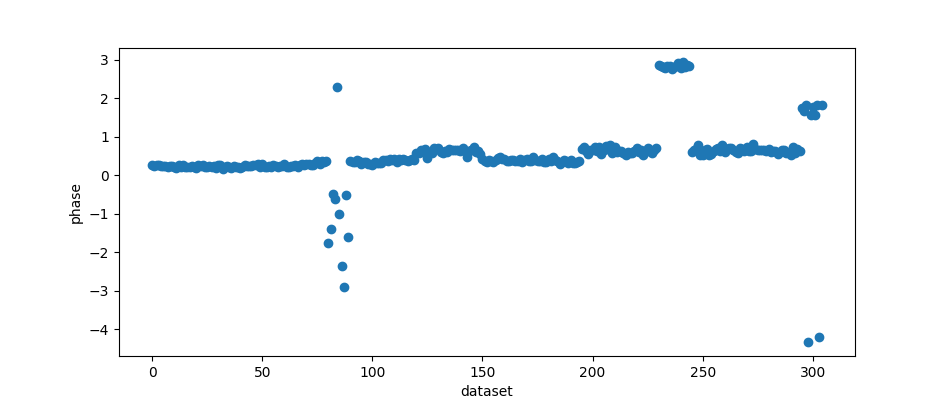

[Text(0, 0.5, 'phase'), Text(0.5, 0, 'dataset')]

In [68]:
_,ax = plt.subplots(figsize=(9.5,4))
ax.scatter(range(len(phases)), phases)
ax.set(xlabel='dataset', ylabel='phase')

<IPython.core.display.Javascript object>


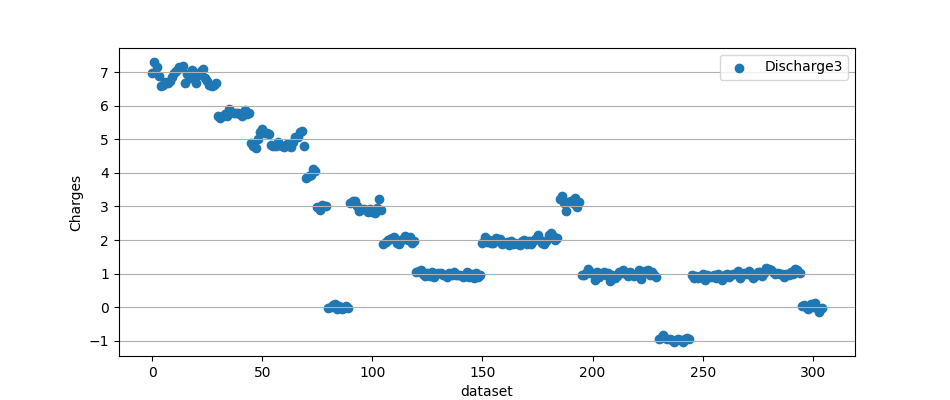

In [26]:
_,ax = plt.subplots(figsize=(9.5,4))
scale = 45.85
extra_scale = 1.3

ax.scatter(range(len(amps)), np.array(amps)/scale/extra_scale, label='Discharge3')
# ax.scatter(range(len(amps2)), np.array(amps2)/scale/extra_scale, label='Discharge3 - bimodal')

ax.legend()
ax.set(xlabel='dataset', ylabel='Charges', ylim=(None,None), xlim=(None,None))
ax.grid(axis='y')
ax.legend()
from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

In [12]:
bdf_z = bdf_discharge[90:95]
bdf_x = bdf_discharge[80:85]
bdf_y = bdf_discharge[85:90]

freq = bdf_z[0].psd2('z')[0]
z_scale = bdf_z[0].psd2('z')[1][freq==71]
for bb in bdf_z:
    z_scale += bb.psd2('z')[1][freq==71]
z_scale /= len(bdf_z)

x_scale = bdf_x[0].psd2('x')[1][freq==71]
for bb in bdf_x:
    x_scale += bb.psd2('x')[1][freq==71]
x_scale /= len(bdf_x)

y_scale = bdf_y[0].psd2('y')[1][freq==71]
for bb in bdf_y:
    y_scale += bb.psd2('y')[1][freq==71]
y_scale /= len(bdf_y)

charges = 3
force = charges * 1.6e-19 * 20 / 8.6e-3 * 0.63 * np.sqrt(10) # in Newtons/sqrt(Hz)
z_scale = force/np.sqrt(z_scale)

fname = r'/data/new_trap/20200614/Bead1/TransFunc/TransFunc_X_2_7e5_250s_1Hz.h5'
tf_x = BeadDataFile.BeadDataFile(fname)
fname = r'/data/new_trap/20200614/Bead1/TransFunc/TransFunc_Y_2_7e5_250s_1Hz.h5'
tf_y = BeadDataFile.BeadDataFile(fname)
fname = r'/data/new_trap/20200614/Bead1/TransFunc/TransFunc_Z_2_7e5_250s_1Hz.h5'
tf_z = BeadDataFile.BeadDataFile(fname)
freq1 = tf_x.psd2('x')[0]
x_scale_71 = 1/np.sqrt(tf_x.psd2('x')[1][freq1==71])
y_scale_71 = 1/np.sqrt(tf_y.psd2('y')[1][freq1==71])
z_scale_71 = 1/np.sqrt(tf_z.psd2('z')[1][freq1==71])

x_scale = x_scale_71*(z_scale/z_scale_71)
y_scale = y_scale_71*(z_scale/z_scale_71)

No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data


In [293]:
charges = 1
force = charges * 1.6e-19 * 20 / 8.6e-3 * 0.63
force

2.3441860465116277e-16

In [267]:
x_scale_71/z_scale_71, x_scale/z_scale

(array([6260391.47359473]), array([6260391.47359473]))

In [10]:
## 100 files of shaking data for nose floor
data_bdfs = load_dir(dirname='/data/new_trap/20200614/Bead1/Shaking/Shaking367/',
                         file_prefix='NoSpinNoShaking0', start_file=0, max_file=100)
freq = data_bdfs[0].psd2('x')[0]
fftx1 = data_bdfs[0].psd2('x')[1]
ffty1 = data_bdfs[0].psd2('y')[1]

fftz1 = data_bdfs[0].psd2('z')[1]
for i in range(1,100):
    fftx1 += data_bdfs[i].psd2('x')[1]
    fftz1 += data_bdfs[i].psd2('z')[1]
    ffty1 += data_bdfs[i].psd2('y')[1]
fftx1/=100
ffty1/=100
fftz1/=100

1000  files in folder
100  files loaded


<IPython.core.display.Javascript object>


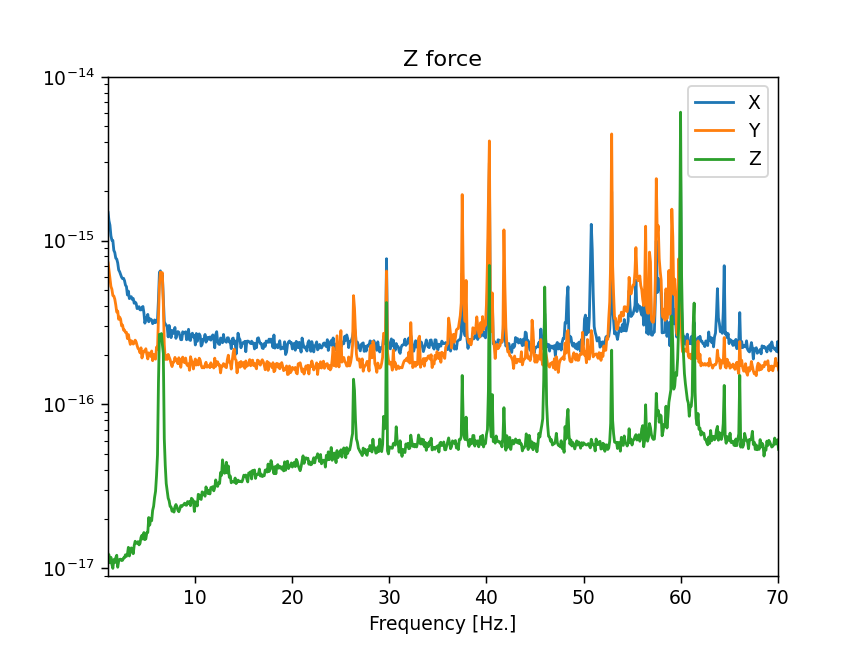

In [13]:
_,ax = plt.subplots()
ax.semilogy(freq, np.sqrt(fftx1)*x_scale, label='X')
ax.semilogy(freq, np.sqrt(ffty1)*y_scale, label='Y')
ax.semilogy(freq, np.sqrt(fftz1)*z_scale, label='Z')
ax.legend()
_ = ax.set(xlim=(1,70), ylim=(9e-18,1e-14), xlabel='Frequency [Hz.]', title=r'Z force')

In [54]:
fftx_noshaking = fftx1
fftz_noshaking = fftz1

In [49]:
fftx_nospin = fftx1
fftz_nospin = fftz1

In [276]:
fftx_spin4 = fftx1
fftz_spin4 = fftz1

<IPython.core.display.Javascript object>


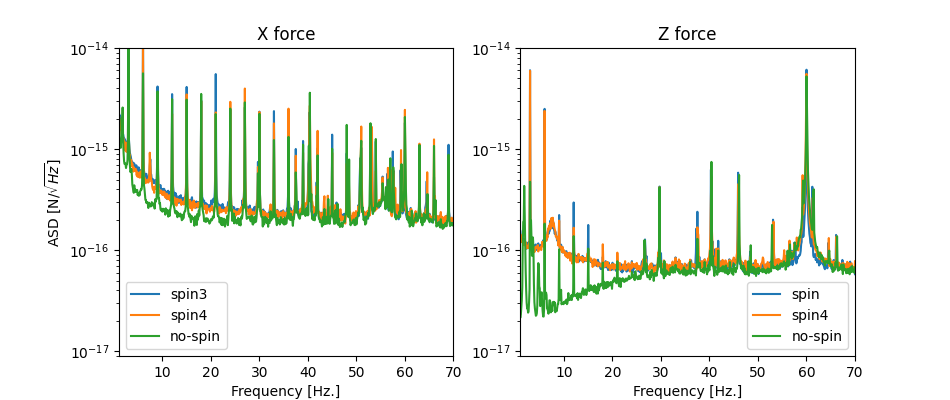

[1.86352626e-17] [2.46192633e-17]


In [277]:
_,ax = plt.subplots(1,2,figsize=(9.5,4))
# tf_freq = np.interp(freq, gfw.tf_freq, gfw.tf_ffts[2])
ax[0].semilogy(freq, np.sqrt(fftx_spin)*x_scale, label='spin3')
ax[0].semilogy(freq, np.sqrt(fftx_spin4)*x_scale, label='spin4')
ax[0].semilogy(freq, np.sqrt(fftx_nospin)*x_scale, label='no-spin')
ax[0].legend()
ax[1].semilogy(freq, np.sqrt(fftz_spin)*z_scale, label='spin')
ax[1].semilogy(freq, np.sqrt(fftz_spin4)*z_scale, label='spin4')
ax[1].semilogy(freq, np.sqrt(fftz_nospin)*z_scale, label='no-spin')
ax[1].legend()
ax[0].set(xlim=(1,70), ylim=(9e-18,1e-14), xlabel='Frequency [Hz.]', ylabel=r'ASD [N/$\sqrt{Hz}$]', title='X force')
_ = ax[1].set(xlim=(1,70), ylim=(9e-18,1e-14), xlabel='Frequency [Hz.]', title=r'Z force')
print(np.sqrt(fftz_noshaking[freq==36])*z_scale/np.sqrt(10), np.sqrt(fftz_spin[freq==36])*z_scale/np.sqrt(10))

<IPython.core.display.Javascript object>


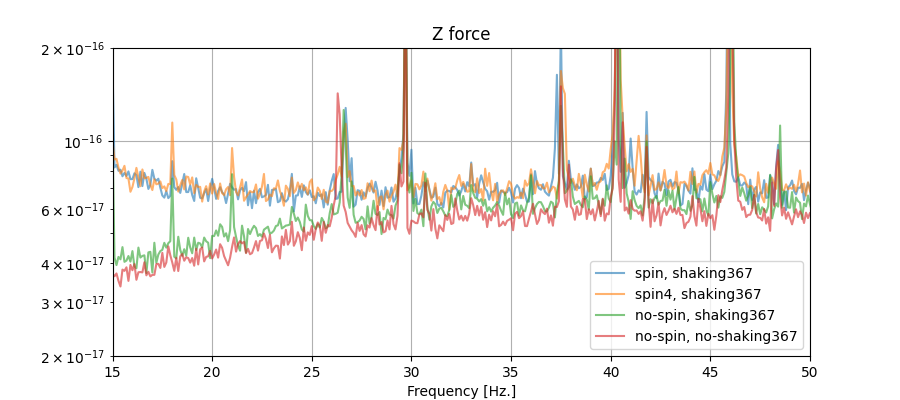

In [278]:
_,ax = plt.subplots(figsize=(9,4))
ax.semilogy(freq, np.sqrt(fftz_spin)*z_scale, alpha=0.6, label='spin, shaking367')
ax.semilogy(freq, np.sqrt(fftz_spin4)*z_scale, alpha=0.6, label='spin4, shaking367')
ax.semilogy(freq, np.sqrt(fftz_nospin)*z_scale, alpha=0.6, label='no-spin, shaking367')
ax.semilogy(freq, np.sqrt(fftz_noshaking)*z_scale, alpha=0.6, label='no-spin, no-shaking367')

ax.legend()
_ = ax.set(xlim=(15,50), ylim=(2e-17,2e-16), xlabel='Frequency [Hz.]', title=r'Z force')
ax.grid()

### Profile Likelihood

In [88]:
389.3-367-7.6/2+1

19.50000000000001

In [7]:
bdf_z = load_dir(dirname='/data/new_trap/20200614/Bead1/Discharge/Discharge3/', start_file=90, max_file=5)

305  files in folder
5  files loaded


In [8]:
data_bdfs2 = load_dir(dirname='/data/new_trap/20200614/Bead1/Shaking/Shaking367/',
                         file_prefix='NoSpinNoShaking0', start_file=0, max_file=100)

1000  files in folder
100  files loaded


In [9]:
## force template
dist = 19.5
z_sep = -17.6
y_offset = 0
test_shaking378 = force_vs_time(dist*1e-6,z_sep*1e-6,200e-6,3,"z",100e-6, yuk_or_grav="yuk",offset_y=y_offset*1e-6, 
                     alpha=1e8, bead_size=3.8e-6)

Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.9e-05 for separation
Taking -1.5e-05 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.90e-05 is selected
A height of -1.50e-05 is selected


In [13]:
## likelihood calculator stuff
ll = likelihood_analyser.LikelihoodAnalyser()
shaking378_template = np.array(test_shaking378[1])*1.85/1.55
gravity_freqs = np.array([36, 33, 42, 18, 21, 39, 24])

In [15]:
fname = r'/data/new_trap/20200614/Bead1/TransFunc/TransFunc_X_2_7e5_250s_1Hz.h5'
tf_x = BeadDataFile.BeadDataFile(fname)
fname = r'/data/new_trap/20200614/Bead1/TransFunc/TransFunc_Y_2_7e5_250s_1Hz.h5'
tf_y = BeadDataFile.BeadDataFile(fname)
fname = r'/data/new_trap/20200614/Bead1/TransFunc/TransFunc_Z_2_7e5_250s_1Hz.h5'
tf_z = BeadDataFile.BeadDataFile(fname)
gfw.build_transfer_function([tf_x, tf_y, tf_z], base_freq=1, number_of_harmonics=90, scale_freq=71, plot=False)

No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data


In [16]:
bandwidth = 2
m1_zscale = gfw.build_z_response(bdf_z, drive_freq=71, charges=3, bandwidth=bandwidth, decimate=10)
gravity_scales = np.array([gfw.scale_Z2])* np.interp(gravity_freqs, gfw.tf_freq, gfw.tf_ffts[2])

***************************************************
Z2-amplitude:  1.81e+02
reduced chi2:  978.8623382755097
***************************************************
Z2-amplitude:  1.85e+02
reduced chi2:  859.6352960178671
***************************************************
Z2-amplitude:  1.85e+02
reduced chi2:  827.0697709678601
***************************************************
Z2-amplitude:  1.75e+02
reduced chi2:  1068.8106427736034
***************************************************
Z2-amplitude:  1.67e+02
reduced chi2:  831.7566273423879
Z2 response (amplitude): -178.62774826751038


In [17]:
gravity_freqs2 = gravity_freqs

In [18]:
noises = []
noises_std =[]
for freq_ in gravity_freqs2:
    tmp_list = []
    for bb in data_bdfs2:
        tmp_list.append(np.std(bb.response_at_freq2('z', drive_freq=freq_, bandwidth=bandwidth)))
    noises.append(np.mean(tmp_list))
    noises_std.append(np.std(tmp_list))
# noises = noises
noises_std = np.array(noises_std)

In [24]:
fname = r'/data/new_trap/20200614/Bead1/Shaking/Shaking367/SpinShaking4_100.h5'
bb = BeadDataFile.BeadDataFile(fname=fname)
np.mean(bb.cant_pos[2]*50) - bb.bead_height

16.00820525190221

In [37]:
def func1(i):
    print(i,'  ******************')
    fname = r'/data/new_trap/20200320/Bead1/Shaking/Shaking2_20200403/NoShaking_1_'+str(i)+'.h5'
    bb = BeadDataFile.BeadDataFile(fname=fname)

    fit_kwargs = {'A': 0, 'phi': 0.2, 'sigma':13.85,
              'error_A': 1, 'error_phi': 0.5, 'errordef': 1, 'error_sigma': 10,
              'limit_phi': [0, 2 * np.pi],
              'limit_A': [-1000, 1000], 'limit_sigma': [0, 1000000],
              'print_level': 0, 'fix_A': True, 'fix_phi': True, 'fix_sigma': True}
    mm_tmp = ll.find_mle_multiHarmoincs(x=bb.z2, template=shaking378_template, scales=gravity_scales, 
                                          signal_freqs=gravity_freqs, bandwidth=2, noises=noises_std/noises_std[0], 
                                          decimate=10, **fit_kwargs)
    return mm_tmp.fval

def func2(i):
    print(i,'  ******************')
    fname = r'/data/new_trap/20200614/Bead1/Shaking/Shaking367/SpinShaking4_'+str(i)+'.h5'
    bb = BeadDataFile.BeadDataFile(fname=fname)

    fit_kwargs = {'A': 0, 'phi': 0.2, 'sigma':10.7,
              'error_A': 1, 'error_phi': 0.5, 'errordef': 1, 'error_sigma': 10,
              'limit_phi': [0, 2 * np.pi],
              'limit_A': [-1000, 1000], 'limit_sigma': [0, 1000000],
              'print_level': 0, 'fix_A': False, 'fix_phi': True, 'fix_sigma': False}
    mm_tmp = ll.find_mle_multiHarmoincs(x=bb.z2, template=shaking378_template, scales=gravity_scales, 
                                          signal_freqs=gravity_freqs, bandwidth=bandwidth, noises=noises_std/noises_std[0],
                                          decimate=10, **fit_kwargs)

    return mm_tmp.values[0]

In [40]:
mle_alpha_spin4 = np.array(Parallel(n_jobs=40)(delayed(func2)(i) for i in tqdm(range(1000))))

100%|██████████| 1000/1000 [00:24<00:00, 37.61it/s]


In [41]:
np.mean(mle_alpha_spin4), np.std(mle_alpha_spin4), np.std(mle_alpha_spin4)/np.sqrt(1000)

(-1.2561022963030113, 8.446979863407215, 0.26711695717944783)

In [32]:
_,ax = plt.subplots()
data = list(mle_alpha_spin4)
avg = np.mean(data)
var = np.var(data)
# From that, we know the shape of the fitted Gaussian.
pdf_x = np.linspace(-25,25,100)
pdf_y = 1.0/np.sqrt(2*np.pi*var)*np.exp(-0.5*(pdf_x-avg)**2/var)

ax.hist(data, range=(-25,25), bins=25, density=True)
# ax.hist(mm_mle_A10, range=(-25,25), bins=30, density=True, alpha=0.4)
# Then we plot :
ax.set(xlim=(-25,25), xlabel=r'$\hat{\alpha} \,[10^{8}]$')
ax.plot(pdf_x,pdf_y,'k--')

print('alpha MLE: ', avg, 'std: ', np.std(data)/np.sqrt(1000))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

alpha MLE:  10.140659304763611 std:  3.151877973309543


<IPython.core.display.Javascript object>


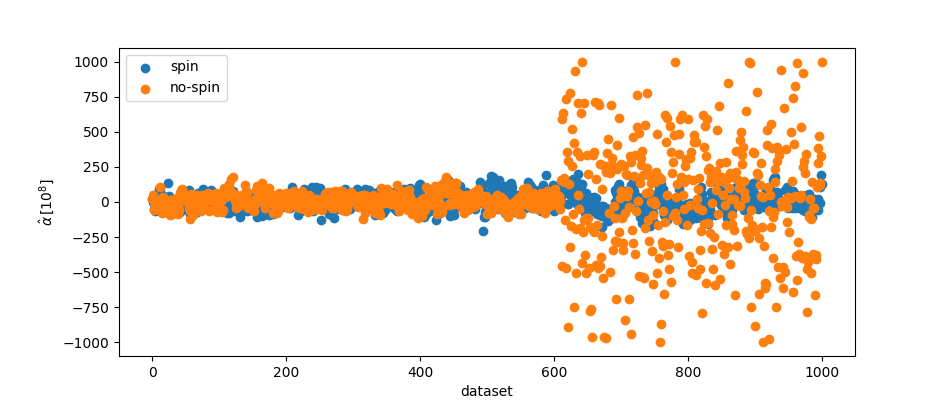

In [117]:
_,ax = plt.subplots(figsize=(9.5,4))
ax.scatter(range(1000), mm_mle_spin, label='spin')
ax.scatter(range(1000), mm_mle_nospin, label='no-spin')
ax.set(xlabel='dataset', ylabel=r'$\hat{\alpha}\,[10^8] $')
ax.legend()

<IPython.core.display.Javascript object>


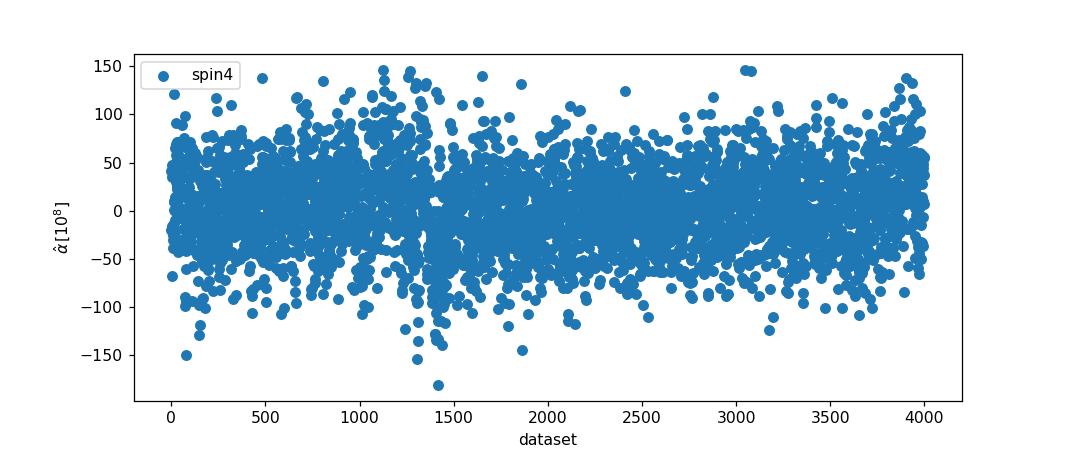

In [320]:
_,ax = plt.subplots(figsize=(9.5,4))
ax.scatter(range(4000), mm_mle_spin4, label='spin4')
ax.set(xlabel='dataset', ylabel=r'$\hat{\alpha}\,[10^8] $')
ax.legend()

In [323]:
alpha_means = [np.mean(mm_mle_spin4[j*100:(j+1)*100]) for j in range(40)]
alpha_stds = [np.std(mm_mle_spin4[j*100:(j+1)*100]) for j in range(40)]

<IPython.core.display.Javascript object>


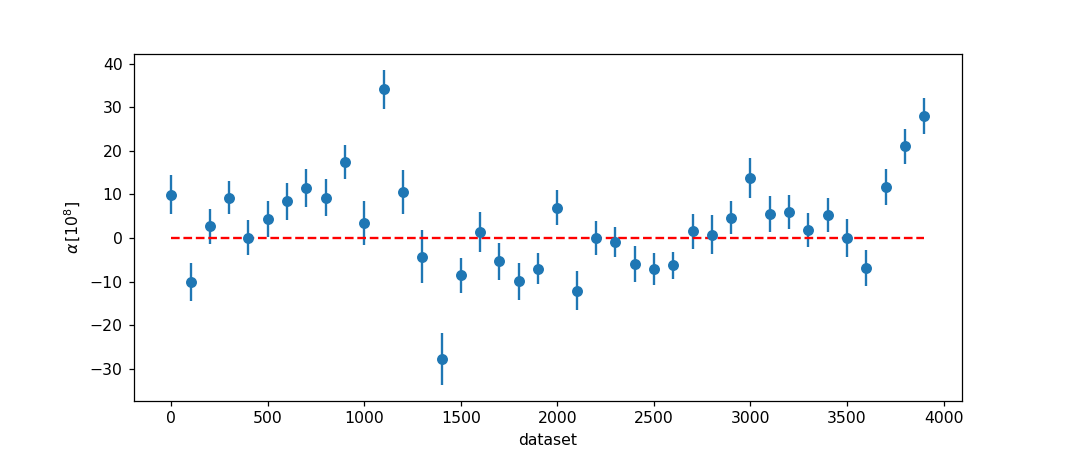

[Text(0, 0.5, '$\\alpha \\,[10^{8}]$'), Text(0.5, 0, 'dataset')]

In [324]:
_,ax = plt.subplots(figsize=(9.5,4))
ax.errorbar(np.arange(0,4000,100), alpha_means, yerr=alpha_stds/np.sqrt(100),fmt='o')
ax.plot(np.arange(0,4000,100), np.arange(0,4000,100)*0, 'r--')
ax.set(xlabel='dataset', ylabel=r'$\alpha \,[10^{8}]$')

In [305]:
phases_freqs_x = []
ffts_freqs = []
for i in range(4000):
    std_freqs_tmp = []
    print(i, '**************')
    fname = r'/data/new_trap/20200614/Bead1/Shaking/Shaking367/SpinShaking4_'+str(i)+'.h5'
    bb = BeadDataFile.BeadDataFile(fname=fname)
    freq = np.fft.rfftfreq(len(bb.x2), 1 / 5000)
    fft_tmp = np.fft.rfft(bb.x2) * 2 / np.sqrt(50000 * 5000)
    angles_tmp = (np.angle(np.fft.rfft(bb.x2)) + np.pi / 2) % (2 * np.pi)
    phases_freqs_tmp = np.array([angles_tmp[freq == freq_] for freq_ in gravity_freqs])
    ffts_freqs_tmp = np.array([fft_tmp[freq == freq_] for freq_ in gravity_freqs])
    
    phases_freqs_x.append(phases_freqs_tmp)
    ffts_freqs.append(ffts_freqs_tmp)
phases_freqs_x = np.array(phases_freqs_x)
ffts_freqs = np.array(ffts_freqs)

0 **************
1 **************
2 **************
3 **************
4 **************
5 **************
6 **************
7 **************
8 **************
9 **************
10 **************
11 **************
12 **************
13 **************
14 **************
15 **************
16 **************
17 **************
18 **************
19 **************
20 **************
21 **************
22 **************
23 **************
24 **************
25 **************
26 **************
27 **************
28 **************
29 **************
30 **************
31 **************
32 **************
33 **************
34 **************
35 **************
36 **************
37 **************
38 **************
39 **************
40 **************
41 **************
42 **************
43 **************
44 **************
45 **************
46 **************
47 **************
48 **************
49 **************
50 **************
51 **************
52 **************
53 **************
54 **************
55 **************
56

439 **************
440 **************
441 **************
442 **************
443 **************
444 **************
445 **************
446 **************
447 **************
448 **************
449 **************
450 **************
451 **************
452 **************
453 **************
454 **************
455 **************
456 **************
457 **************
458 **************
459 **************
460 **************
461 **************
462 **************
463 **************
464 **************
465 **************
466 **************
467 **************
468 **************
469 **************
470 **************
471 **************
472 **************
473 **************
474 **************
475 **************
476 **************
477 **************
478 **************
479 **************
480 **************
481 **************
482 **************
483 **************
484 **************
485 **************
486 **************
487 **************
488 **************
489 **************
490 **************
491 ********

873 **************
874 **************
875 **************
876 **************
877 **************
878 **************
879 **************
880 **************
881 **************
882 **************
883 **************
884 **************
885 **************
886 **************
887 **************
888 **************
889 **************
890 **************
891 **************
892 **************
893 **************
894 **************
895 **************
896 **************
897 **************
898 **************
899 **************
900 **************
901 **************
902 **************
903 **************
904 **************
905 **************
906 **************
907 **************
908 **************
909 **************
910 **************
911 **************
912 **************
913 **************
914 **************
915 **************
916 **************
917 **************
918 **************
919 **************
920 **************
921 **************
922 **************
923 **************
924 **************
925 ********

1289 **************
1290 **************
1291 **************
1292 **************
1293 **************
1294 **************
1295 **************
1296 **************
1297 **************
1298 **************
1299 **************
1300 **************
1301 **************
1302 **************
1303 **************
1304 **************
1305 **************
1306 **************
1307 **************
1308 **************
1309 **************
1310 **************
1311 **************
1312 **************
1313 **************
1314 **************
1315 **************
1316 **************
1317 **************
1318 **************
1319 **************
1320 **************
1321 **************
1322 **************
1323 **************
1324 **************
1325 **************
1326 **************
1327 **************
1328 **************
1329 **************
1330 **************
1331 **************
1332 **************
1333 **************
1334 **************
1335 **************
1336 **************
1337 **************
1338 **************


1699 **************
1700 **************
1701 **************
1702 **************
1703 **************
1704 **************
1705 **************
1706 **************
1707 **************
1708 **************
1709 **************
1710 **************
1711 **************
1712 **************
1713 **************
1714 **************
1715 **************
1716 **************
1717 **************
1718 **************
1719 **************
1720 **************
1721 **************
1722 **************
1723 **************
1724 **************
1725 **************
1726 **************
1727 **************
1728 **************
1729 **************
1730 **************
1731 **************
1732 **************
1733 **************
1734 **************
1735 **************
1736 **************
1737 **************
1738 **************
1739 **************
1740 **************
1741 **************
1742 **************
1743 **************
1744 **************
1745 **************
1746 **************
1747 **************
1748 **************


2110 **************
2111 **************
2112 **************
2113 **************
2114 **************
2115 **************
2116 **************
2117 **************
2118 **************
2119 **************
2120 **************
2121 **************
2122 **************
2123 **************
2124 **************
2125 **************
2126 **************
2127 **************
2128 **************
2129 **************
2130 **************
2131 **************
2132 **************
2133 **************
2134 **************
2135 **************
2136 **************
2137 **************
2138 **************
2139 **************
2140 **************
2141 **************
2142 **************
2143 **************
2144 **************
2145 **************
2146 **************
2147 **************
2148 **************
2149 **************
2150 **************
2151 **************
2152 **************
2153 **************
2154 **************
2155 **************
2156 **************
2157 **************
2158 **************
2159 **************


2521 **************
2522 **************
2523 **************
2524 **************
2525 **************
2526 **************
2527 **************
2528 **************
2529 **************
2530 **************
2531 **************
2532 **************
2533 **************
2534 **************
2535 **************
2536 **************
2537 **************
2538 **************
2539 **************
2540 **************
2541 **************
2542 **************
2543 **************
2544 **************
2545 **************
2546 **************
2547 **************
2548 **************
2549 **************
2550 **************
2551 **************
2552 **************
2553 **************
2554 **************
2555 **************
2556 **************
2557 **************
2558 **************
2559 **************
2560 **************
2561 **************
2562 **************
2563 **************
2564 **************
2565 **************
2566 **************
2567 **************
2568 **************
2569 **************
2570 **************


2931 **************
2932 **************
2933 **************
2934 **************
2935 **************
2936 **************
2937 **************
2938 **************
2939 **************
2940 **************
2941 **************
2942 **************
2943 **************
2944 **************
2945 **************
2946 **************
2947 **************
2948 **************
2949 **************
2950 **************
2951 **************
2952 **************
2953 **************
2954 **************
2955 **************
2956 **************
2957 **************
2958 **************
2959 **************
2960 **************
2961 **************
2962 **************
2963 **************
2964 **************
2965 **************
2966 **************
2967 **************
2968 **************
2969 **************
2970 **************
2971 **************
2972 **************
2973 **************
2974 **************
2975 **************
2976 **************
2977 **************
2978 **************
2979 **************
2980 **************


3343 **************
3344 **************
3345 **************
3346 **************
3347 **************
3348 **************
3349 **************
3350 **************
3351 **************
3352 **************
3353 **************
3354 **************
3355 **************
3356 **************
3357 **************
3358 **************
3359 **************
3360 **************
3361 **************
3362 **************
3363 **************
3364 **************
3365 **************
3366 **************
3367 **************
3368 **************
3369 **************
3370 **************
3371 **************
3372 **************
3373 **************
3374 **************
3375 **************
3376 **************
3377 **************
3378 **************
3379 **************
3380 **************
3381 **************
3382 **************
3383 **************
3384 **************
3385 **************
3386 **************
3387 **************
3388 **************
3389 **************
3390 **************
3391 **************
3392 **************


3753 **************
3754 **************
3755 **************
3756 **************
3757 **************
3758 **************
3759 **************
3760 **************
3761 **************
3762 **************
3763 **************
3764 **************
3765 **************
3766 **************
3767 **************
3768 **************
3769 **************
3770 **************
3771 **************
3772 **************
3773 **************
3774 **************
3775 **************
3776 **************
3777 **************
3778 **************
3779 **************
3780 **************
3781 **************
3782 **************
3783 **************
3784 **************
3785 **************
3786 **************
3787 **************
3788 **************
3789 **************
3790 **************
3791 **************
3792 **************
3793 **************
3794 **************
3795 **************
3796 **************
3797 **************
3798 **************
3799 **************
3800 **************
3801 **************
3802 **************


In [122]:
gravity_freqs

array([36, 33, 42, 18, 21, 39, 24])

In [280]:
np.sqrt(5000)

70.71067811865476

In [133]:
x_36 = [np.mean(ffts_freqs[j*50:(j+1)*50,i,0]) for j in range(80)]

21


<IPython.core.display.Javascript object>


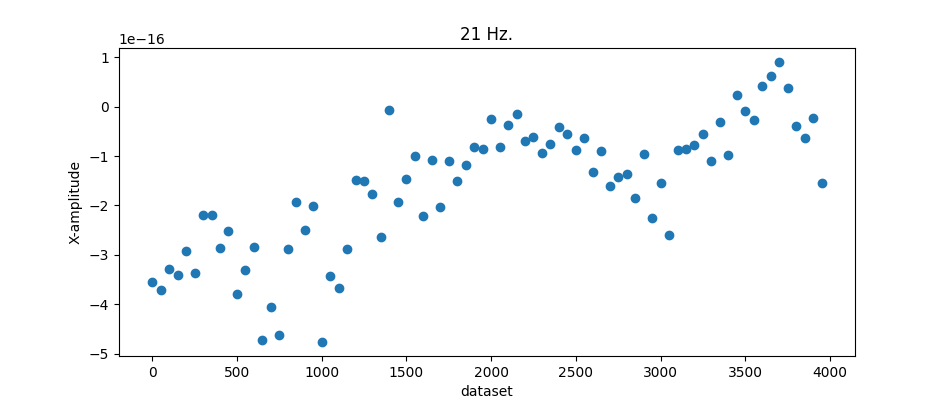

[Text(0, 0.5, 'X-amplitude'),
 Text(0.5, 0, 'dataset'),
 Text(0.5, 1.0, '21 Hz.')]

In [290]:
i=4
print(gravity_freqs[i])
x_36 = [np.mean(ffts_freqs[j*50:(j+1)*50,i,0]) for j in range(80)]
_,ax = plt.subplots(figsize=(9.5,4))
ax.scatter(np.arange(0,4000,50), x_36*x_scale*np.sqrt(5000)/np.sqrt(10))
ax.set(title=str(gravity_freqs[i])+' Hz.', xlabel='dataset', ylabel='X-amplitude')

<IPython.core.display.Javascript object>


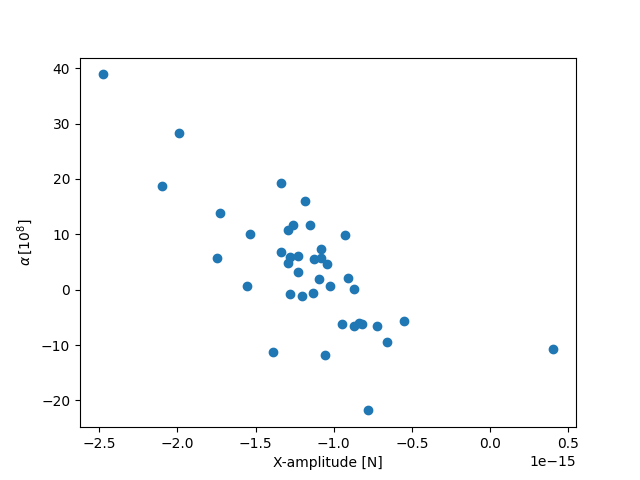

[Text(0, 0.5, '$\\alpha \\,[10^{8}]$'), Text(0.5, 0, 'X-amplitude [N]')]

In [286]:
x_36 = [np.mean(ffts_freqs[j*100:(j+1)*100,0,0]) for j in range(40)]
alpha_means_corr = [np.mean(mm_mle_spin4[j*100:(j+1)*100]) for j in range(40)]
_, ax = plt.subplots()
ax.scatter(x_36*x_scale*np.sqrt(5000)/np.sqrt(10), alpha_means_corr)
ax.set(ylabel=r'$\alpha \,[10^{8}]$', xlabel='X-amplitude [N]')

<IPython.core.display.Javascript object>


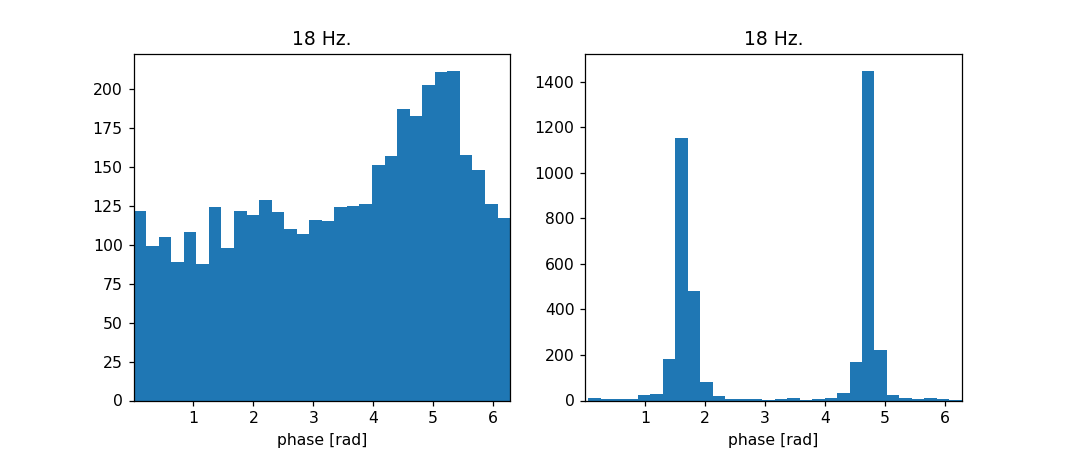

[[(0.001, 6.282185307179586),
  Text(0.5, 0, 'phase [rad]'),
  Text(0.5, 1.0, '18 Hz.')],
 [(0.001, 6.282185307179586),
  Text(0.5, 0, 'phase [rad]'),
  Text(0.5, 1.0, '18 Hz.')]]

In [389]:
i=3
_,ax = plt.subplots(1,2,figsize=(9.5,4))
ax[0].hist(phases_freqs[:,i,0],bins=30)
ax[1].hist(phases_freqs_x[:,i,0],bins=30)
[a.set(xlabel='phase [rad]', xlim=(0+0.001,2*np.pi-0.001), title=str(gravity_freqs[i])+' Hz.') for a in ax]

i=3
_,ax = plt.subplots(figsize=(9.5,4))
ax.scatter(range(4000), phases_freqs_x[:,i,0])
# ax.scatter(range(4000), phases_freqs[:,i,0], alpha=0.5)
# ax.scatter( phases_freqs_x[:,i,0],  phases_freqs[:,i,0])

In [366]:
from multiprocessing import Pool

def func3(i):
    print(i,'  ******************')
    fname = r'/data/new_trap/20200614/Bead1/Shaking/Shaking367/SpinShaking4_'+str(i)+'.h5'
    bb = BeadDataFile.BeadDataFile(fname=fname)

    return np.std(bb.feedback[2])
    
if __name__ == '__main__':
    pool = Pool(processes=20)                         # Create a multiprocessing Pool
    quad_sum4 = np.array(pool.map(func3, range(0,4000)))
    pool.close()

0   ******************
500   ******************
50   ******************
200   ******************
100   ******************
800   ******************
950   ******************
550   ******************
650   ******************
300   ******************
350   ******************
250   ******************
750   ******************
450   ******************
700   ******************
150   ******************
400   ******************
600   ******************
850   ******************
900   ******************
551   ******************
801   ******************
651   ******************
601   ******************
552   ******************
802   ******************
751   ******************
951   ******************
701   ******************
1   ******************
851   ******************
602   ******************
553   ******************
702   ******************
752   ******************
803   ******************
652   ******************
952   ******************
2   ******************
901   ******************
852   *

973   ******************
575   ******************
772   ******************
57   ******************
110   ******************
722   ******************
872   ******************
18   ******************
924   ******************
265   ******************
826   ******************
773   ******************
457   ******************
210   ******************
624   ******************
576   ******************
974   ******************
509   ******************
925   ******************
416   ******************
19   ******************
672   ******************
774   ******************
827   ******************
723   ******************
975   ******************
873   ******************
577   ******************
625   ******************
266   ******************
159   ******************
926   ******************
510   ******************
20   ******************
309   ******************
775   ******************
828   ******************
874   ******************
578   ******************
724   ******************
976 

892   ******************
1152   ******************
165   ******************
1004   ******************
1200   ******************
740   ******************
685   ******************
1250   ******************
1054   ******************
428   ******************
279   ******************
39   ******************
1104   ******************
1251   ******************
1005   ******************
1153   ******************
893   ******************
1055   ******************
1105   ******************
64   ******************
117   ******************
686   ******************
894   ******************
1154   ******************
520   ******************
1006   ******************
1252   ******************
1056   ******************
166   ******************
741   ******************
1201   ******************
429   ******************
40   ******************
217   ******************
280   ******************
1106   ******************
1155   ******************
1253   ******************
895   ******************
1007   **

1022   ******************
1230   ******************
1174   ******************
222   ******************
1231   ******************
1082   ******************
1133   ******************
1280   ******************
1320   ******************
1359   ******************
1407   ******************
1232   ******************
70   ******************
447   ******************
1233   ******************
1321   ******************
1175   ******************
1408   ******************
326   ******************
698   ******************
1134   ******************
1281   ******************
1083   ******************
1023   ******************
1360   ******************
292   ******************
526   ******************
1322   ******************
123   ******************
1409   ******************
1234   ******************
1084   ******************
1282   ******************
470   ******************
223   ******************
174   ******************
448   ******************
1135   ******************
1361   ******************

1708   ******************
1192   ******************
76   ******************
1431   ******************
1562   ******************
1757   ******************
1514   ******************
1348   ******************
477   ******************
340   ******************
1462   ******************
1660   ******************
1709   ******************
1377   ******************
1349   ******************
129   ******************
1037   ******************
1605   ******************
181   ******************
478   ******************
1515   ******************
1193   ******************
341   ******************
1758   ******************
1563   ******************
77   ******************
381   ******************
1432   ******************
230   ******************
479   ******************
532   ******************
1800   ******************
1661   ******************
1710   ******************
1606   ******************
382   ******************
480   ******************
1801   ******************
231   ******************
383

1825   ******************
1726   ******************
1957   ******************
1686   ******************
1866   ******************
1621   ******************
2007   ******************
239   ******************
1392   ******************
88   ******************
1572   ******************
1916   ******************
1826   ******************
1958   ******************
1867   ******************
545   ******************
1687   ******************
1767   ******************
2008   ******************
1622   ******************
1868   ******************
1688   ******************
1917   ******************
1827   ******************
1393   ******************
2009   ******************
89   ******************
240   ******************
1828   ******************
136   ******************
2010   ******************
1869   ******************
1689   ******************
1048   ******************
1472   ******************
1918   ******************
1623   ******************
1959   ******************
1528   *************

2213   ******************
1935   ******************
1966   ******************
1587   ******************
2064   ******************
1784   ******************
496   ******************
1889   ******************
2258   ******************
1845   ******************
1745   ******************
1491   ******************
2301   ******************
1785   ******************
1638   ******************
2157   ******************
1890   ******************
2214   ******************
2065   ******************
197   ******************
1492   ******************
2034   ******************
1746   ******************
2259   ******************
144   ******************
1588   ******************
1786   ******************
2215   ******************
1967   ******************
1891   ******************
1747   ******************
1493   ******************
1936   ******************
2066   ******************
2216   ******************
2260   ******************
1846   ******************
1639   ******************
1534   ********

2565   ******************
2048   ******************
2372   ******************
1942   ******************
2272   ******************
1541   ******************
2711   ******************
2468   ******************
2613   ******************
2049   ******************
2241   ******************
2566   ******************
2657   ******************
2373   ******************
2310   ******************
2469   ******************
2168   ******************
2712   ******************
2510   ******************
1975   ******************
2752   ******************
2614   ******************
2413   ******************
2803   ******************
2567   ******************
2374   ******************
2077   ******************
2850   ******************
2242   ******************
2470   ******************
2713   ******************
2273   ******************
1542   ******************
2615   ******************
2115   ******************
2568   ******************
2375   ******************
2471   ******************
2714   *****

2670   ******************
2590   ******************
2289   ******************
2736   ******************
2962   ******************
2639   ******************
2916   ******************
2859   ******************
2591   ******************
2321   ******************
2399   ******************
2963   ******************
2087   ******************
2497   ******************
2917   ******************
2640   ******************
2737   ******************
2766   ******************
2671   ******************
2419   ******************
3001   ******************
2592   ******************
2524   ******************
2498   ******************
2964   ******************
3050   ******************
1981   ******************
2178   ******************
2290   ******************
2122   ******************
2641   ******************
2918   ******************
2738   ******************
2965   ******************
3051   ******************
2593   ******************
2919   ******************
2322   ******************
2739   *****

2779   ******************
3122   ******************
2684   ******************
3206   ******************
2297   ******************
3123   ******************
2136   ******************
2426   ******************
3169   ******************
2946   ******************
3124   ******************
2336   ******************
3263   ******************
3075   ******************
2538   ******************
2865   ******************
3014   ******************
2685   ******************
3170   ******************
2947   ******************
3125   ******************
3076   ******************
3264   ******************
3207   ******************
2780   ******************
2337   ******************
2190   ******************
2866   ******************
1987   ******************
2948   ******************
2099   ******************
3171   ******************
3077   ******************
3126   ******************
2686   ******************
3265   ******************
2338   ******************
2539   ******************
2427   *****

3650   ******************
3601   ******************
3357   ******************
3552   ******************
3507   ******************
3459   ******************
3322   ******************
2794   ******************
3022   ******************
2441   ******************
2825   ******************
2199   ******************
3651   ******************
3602   ******************
3197   ******************
3553   ******************
3404   ******************
3508   ******************
3460   ******************
2795   ******************
3652   ******************
3603   ******************
3198   ******************
3509   ******************
3461   ******************
3554   ******************
2876   ******************
3288   ******************
3220   ******************
3323   ******************
3653   ******************
3604   ******************
2442   ******************
3199   ******************
2143   ******************
3462   ******************
2826   ******************
3510   ******************
3555   *****

3663   ******************
3907   ******************
3336   ******************
3031   ******************
3241   ******************
3578   ******************
3535   ******************
3774   ******************
3489   ******************
3860   ******************
3908   ******************
3711   ******************
3376   ******************
3032   ******************
3297   ******************
3579   ******************
3623   ******************
3775   ******************
3861   ******************
2832   ******************
3814   ******************
3242   ******************
3909   ******************
3490   ******************
3377   ******************
3712   ******************
3337   ******************
3580   ******************
3033   ******************
3862   ******************
3776   ******************
3910   ******************
3298   ******************
3378   ******************
3491   ******************
3713   ******************
3624   ******************
3581   ******************
3954   *****

3545   ******************
3873   ******************
3743   ******************
3421   ******************
3832   ******************
2844   ******************
3937   ******************
3677   ******************
3647   ******************
3744   ******************
3938   ******************
3833   ******************
2845   ******************
3964   ******************
3648   ******************
3939   ******************
3745   ******************
3649   ******************
3422   ******************
2846   ******************
3834   ******************
3678   ******************
3874   ******************
3546   ******************
3965   ******************
3940   ******************
3746   ******************
3941   ******************
2847   ******************
3747   ******************
3966   ******************
3423   ******************
3835   ******************
3679   ******************
3875   ******************
3547   ******************
3748   ******************
3942   ******************
2848   *****

In [367]:
quad_sum_means = [np.mean(quad_sum4[j*100:(j+1)*100]) for j in range(40)]
quad_sum_stds = [np.std(quad_sum4[j*100:(j+1)*100]) for j in range(40)]

<IPython.core.display.Javascript object>


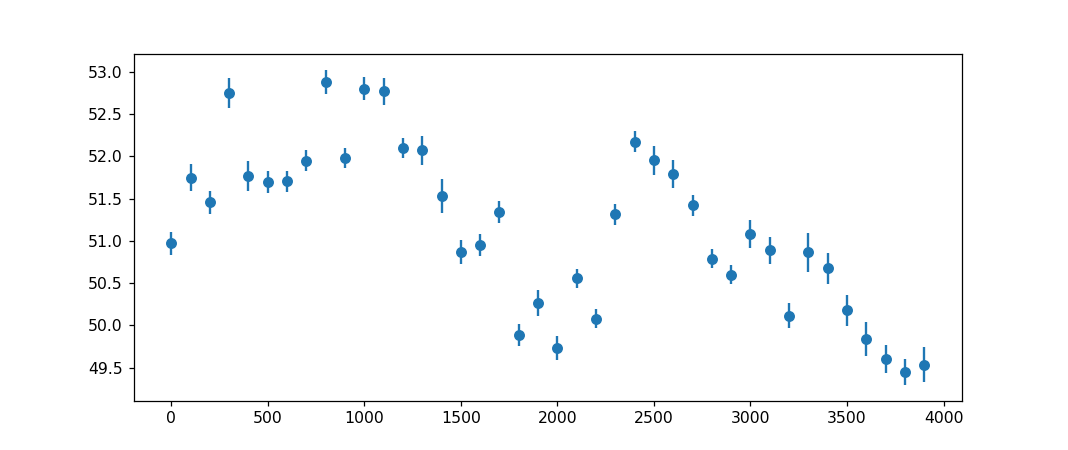

<ErrorbarContainer object of 3 artists>

In [368]:
_,ax = plt.subplots(figsize=(9.5,4))
ax.errorbar(np.arange(0,4000,100), quad_sum_means, yerr=quad_sum_stds/np.sqrt(100),fmt='o')

In [348]:
##X3

## 100 files of shaking data for nose floor
data_bdfs = load_dir(dirname='/data/new_trap/20200614/Bead1/Shaking/Shaking367/',
                         file_prefix='SpinShaking4', start_file=0, max_file=100)
freq = data_bdfs[0].psd2('x')[0]
fftx1 = np.abs(np.fft.rfft(data_bdfs[0].x3,norm='ortho'))**2

for i in range(1,100):
    fftx1 += np.abs(np.fft.rfft(data_bdfs[i].x3,norm='ortho'))**2
fftx1/=100

4000  files in folder
100  files loaded


<IPython.core.display.Javascript object>


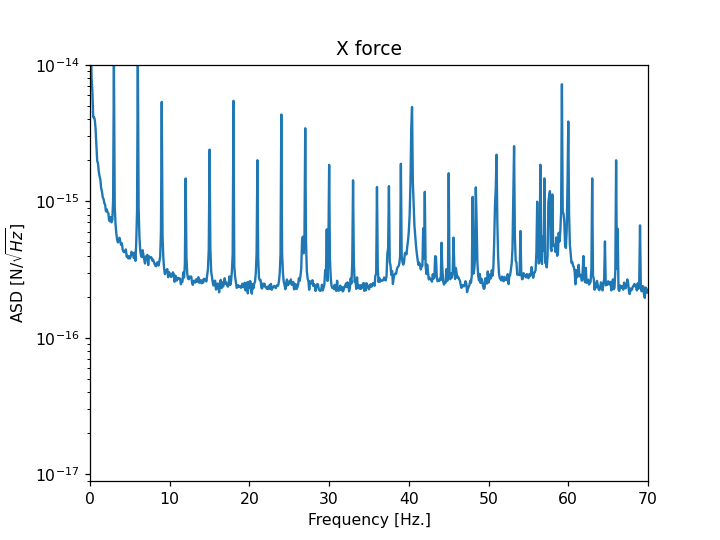

[(9e-18, 1e-14),
 Text(0, 0.5, 'ASD [N/$\\sqrt{Hz}$]'),
 (0.0, 70.0),
 Text(0.5, 0, 'Frequency [Hz.]'),
 Text(0.5, 1.0, 'X force')]

In [356]:
_,ax = plt.subplots()
ax.semilogy(freq, np.sqrt(fftx1)*1e-17)
ax.set(xlim=(0,70), ylim=(9e-18,1e-14), xlabel='Frequency [Hz.]', ylabel=r'ASD [N/$\sqrt{Hz}$]', title='X force')

In [46]:
def getPhase_scanY(i):
    print(i,'  ******************')
    fname = r'/data/new_trap/20200614/Bead1/Shaking/Shaking367/Shaking2_'+str(i)+'.h5'
    bb = BeadDataFile.BeadDataFile(fname=fname)
    x = bb.x2
    fft_ = np.fft.rfft(x,norm='ortho')
    freq_ = np.fft.rfftfreq(len(x), d=1./5000)
    return [np.angle(fft_[freq_==harm*3]) for harm in range(1,14)]

In [47]:
test_phase2 = np.array(Parallel(n_jobs=20)(delayed(getPhase_scanY)(i) for i in tqdm(range(1000)))).T[0]


100%|██████████| 1000/1000 [00:26<00:00, 35.83it/s]

In [48]:
_,ax = plt.subplots(3,4,figsize=(9,8.5), sharex=True)
i = 0
_ = [a.hist(test_phase[j][:3000]%(2*np.pi), label=str(np.arange(1,13)[j]*3)+'Hz. spin', bins=60, range=(0,2*np.pi)) for j,a in enumerate(ax.flatten())]
_ = [a.hist(test_phase2[j][:3000]%(2*np.pi), label=str(np.arange(1,13)[j]*3)+'Hz. no spin', alpha=0.5, bins=60, range=(0,2*np.pi)) for j,a in enumerate(ax.flatten())]
# _ = ax.hist(test_phase2[i][:3000]%(2*np.pi), label=str(np.arange(1,13)[i]*3)+' constant', alpha=0.6, bins=60, range=(0,2*np.pi))
_ = [a.legend() for a in ax.flatten()]
_ = [a.set(xlabel='phase [rad]') for a in ax.flatten()]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …